In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import numpy as np
import tensorflow as tf

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

2024-03-28 08:55:37.888275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 08:55:37.888296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 08:55:37.888812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [21]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, img_size=(300, 300)):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path, width=img_size[0], height=img_size[1]))

In [5]:
last_conv_layer_name = "top_conv"

model_path = 'models/efficientnet_v2_trash_box.keras'
model = tf.keras.models.load_model(model_path)

# Remove last layer's softmax
model.layers[-1].activation = None

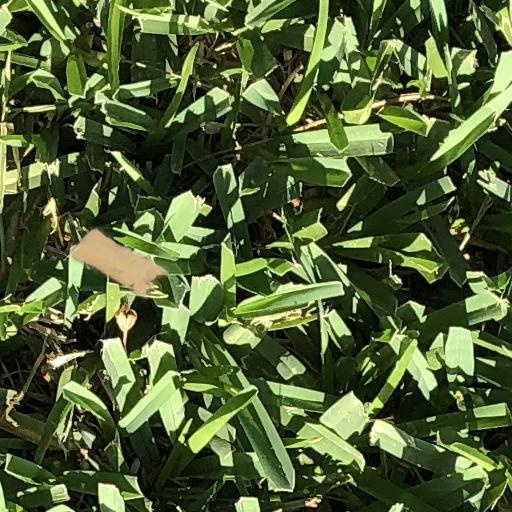

In [6]:
# The local path to our target image
img_path = '/home/deeplearning/AI/datasets/TrashBox/train/sub_classes/cigarette butt/cigarette_butt 19.jpg'
display(Image(img_path))

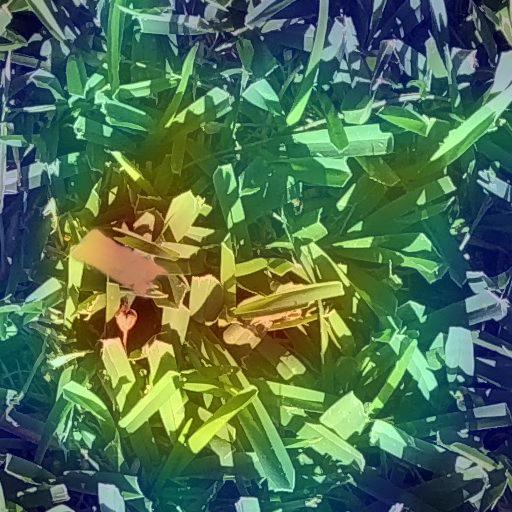

In [7]:
img_size = (300, 300)
img_array = get_img_array(img_path, size=img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(img_path, heatmap)

### OpenWaste

In [10]:
last_conv_layer_name = "top_conv"

model_path = 'models/efficientnet_v2_open_waste.keras'
model = tf.keras.models.load_model(model_path)

# Remove last layer's softmax
model.layers[-1].activation = None

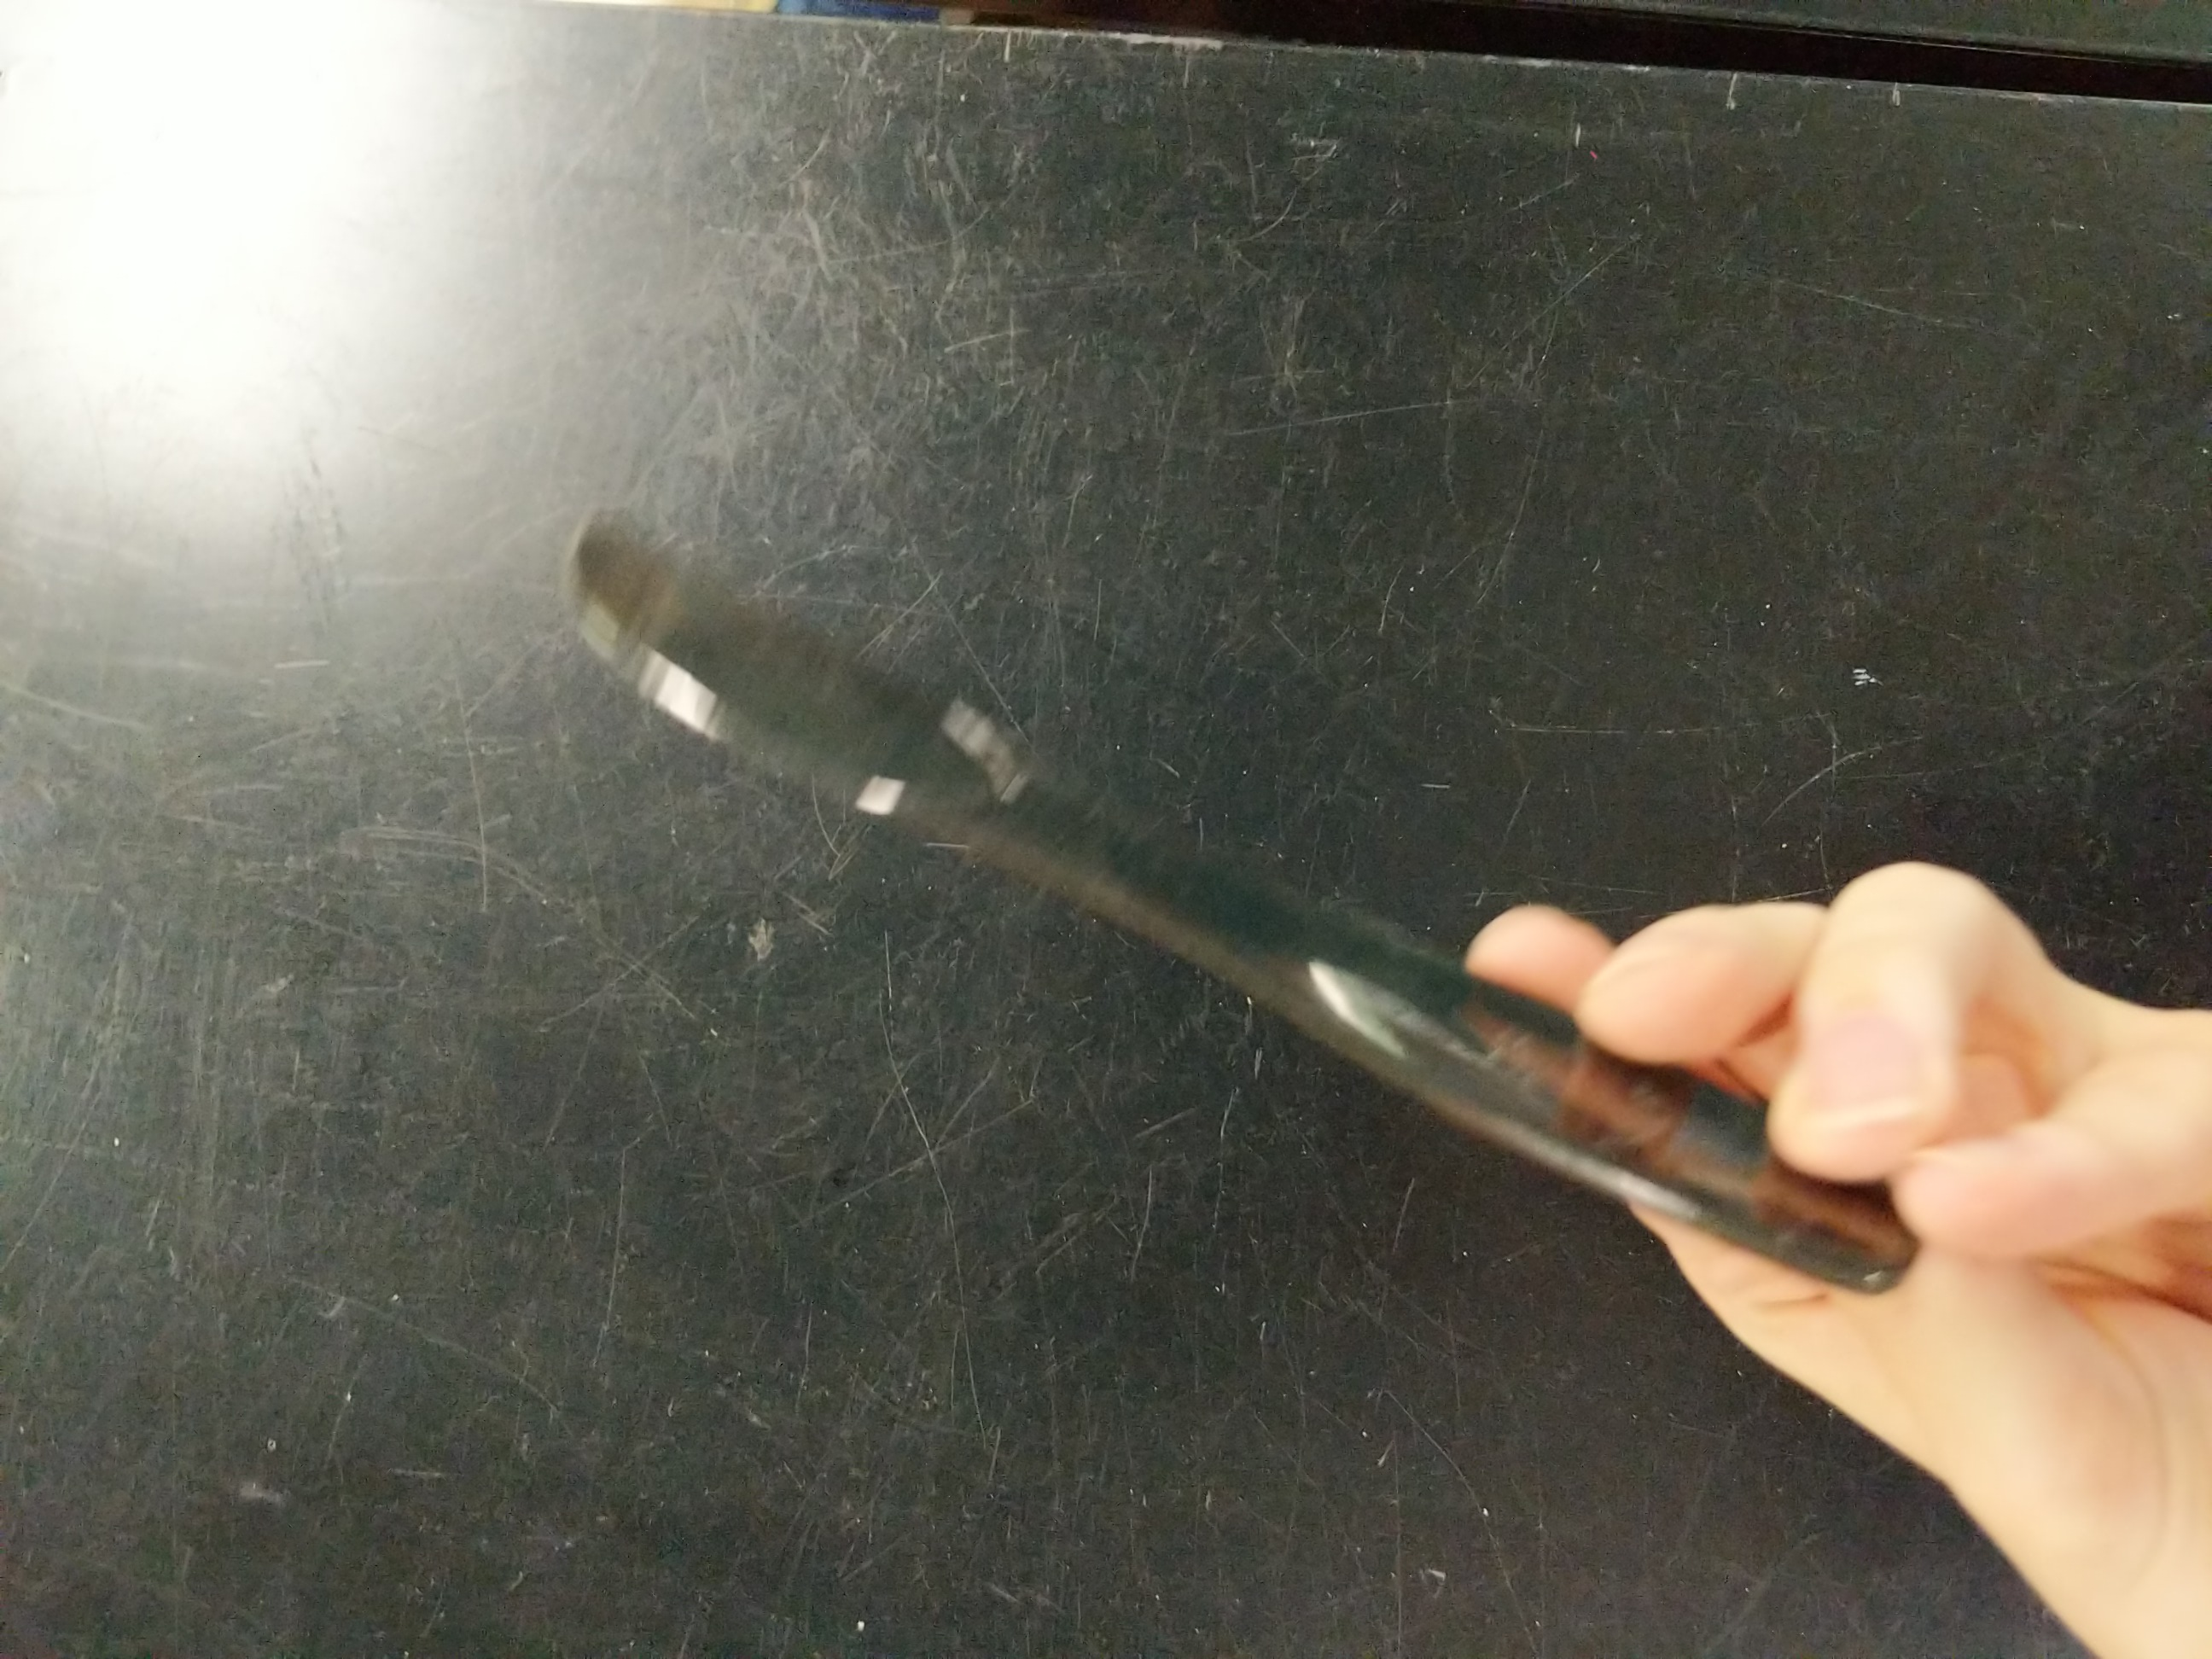

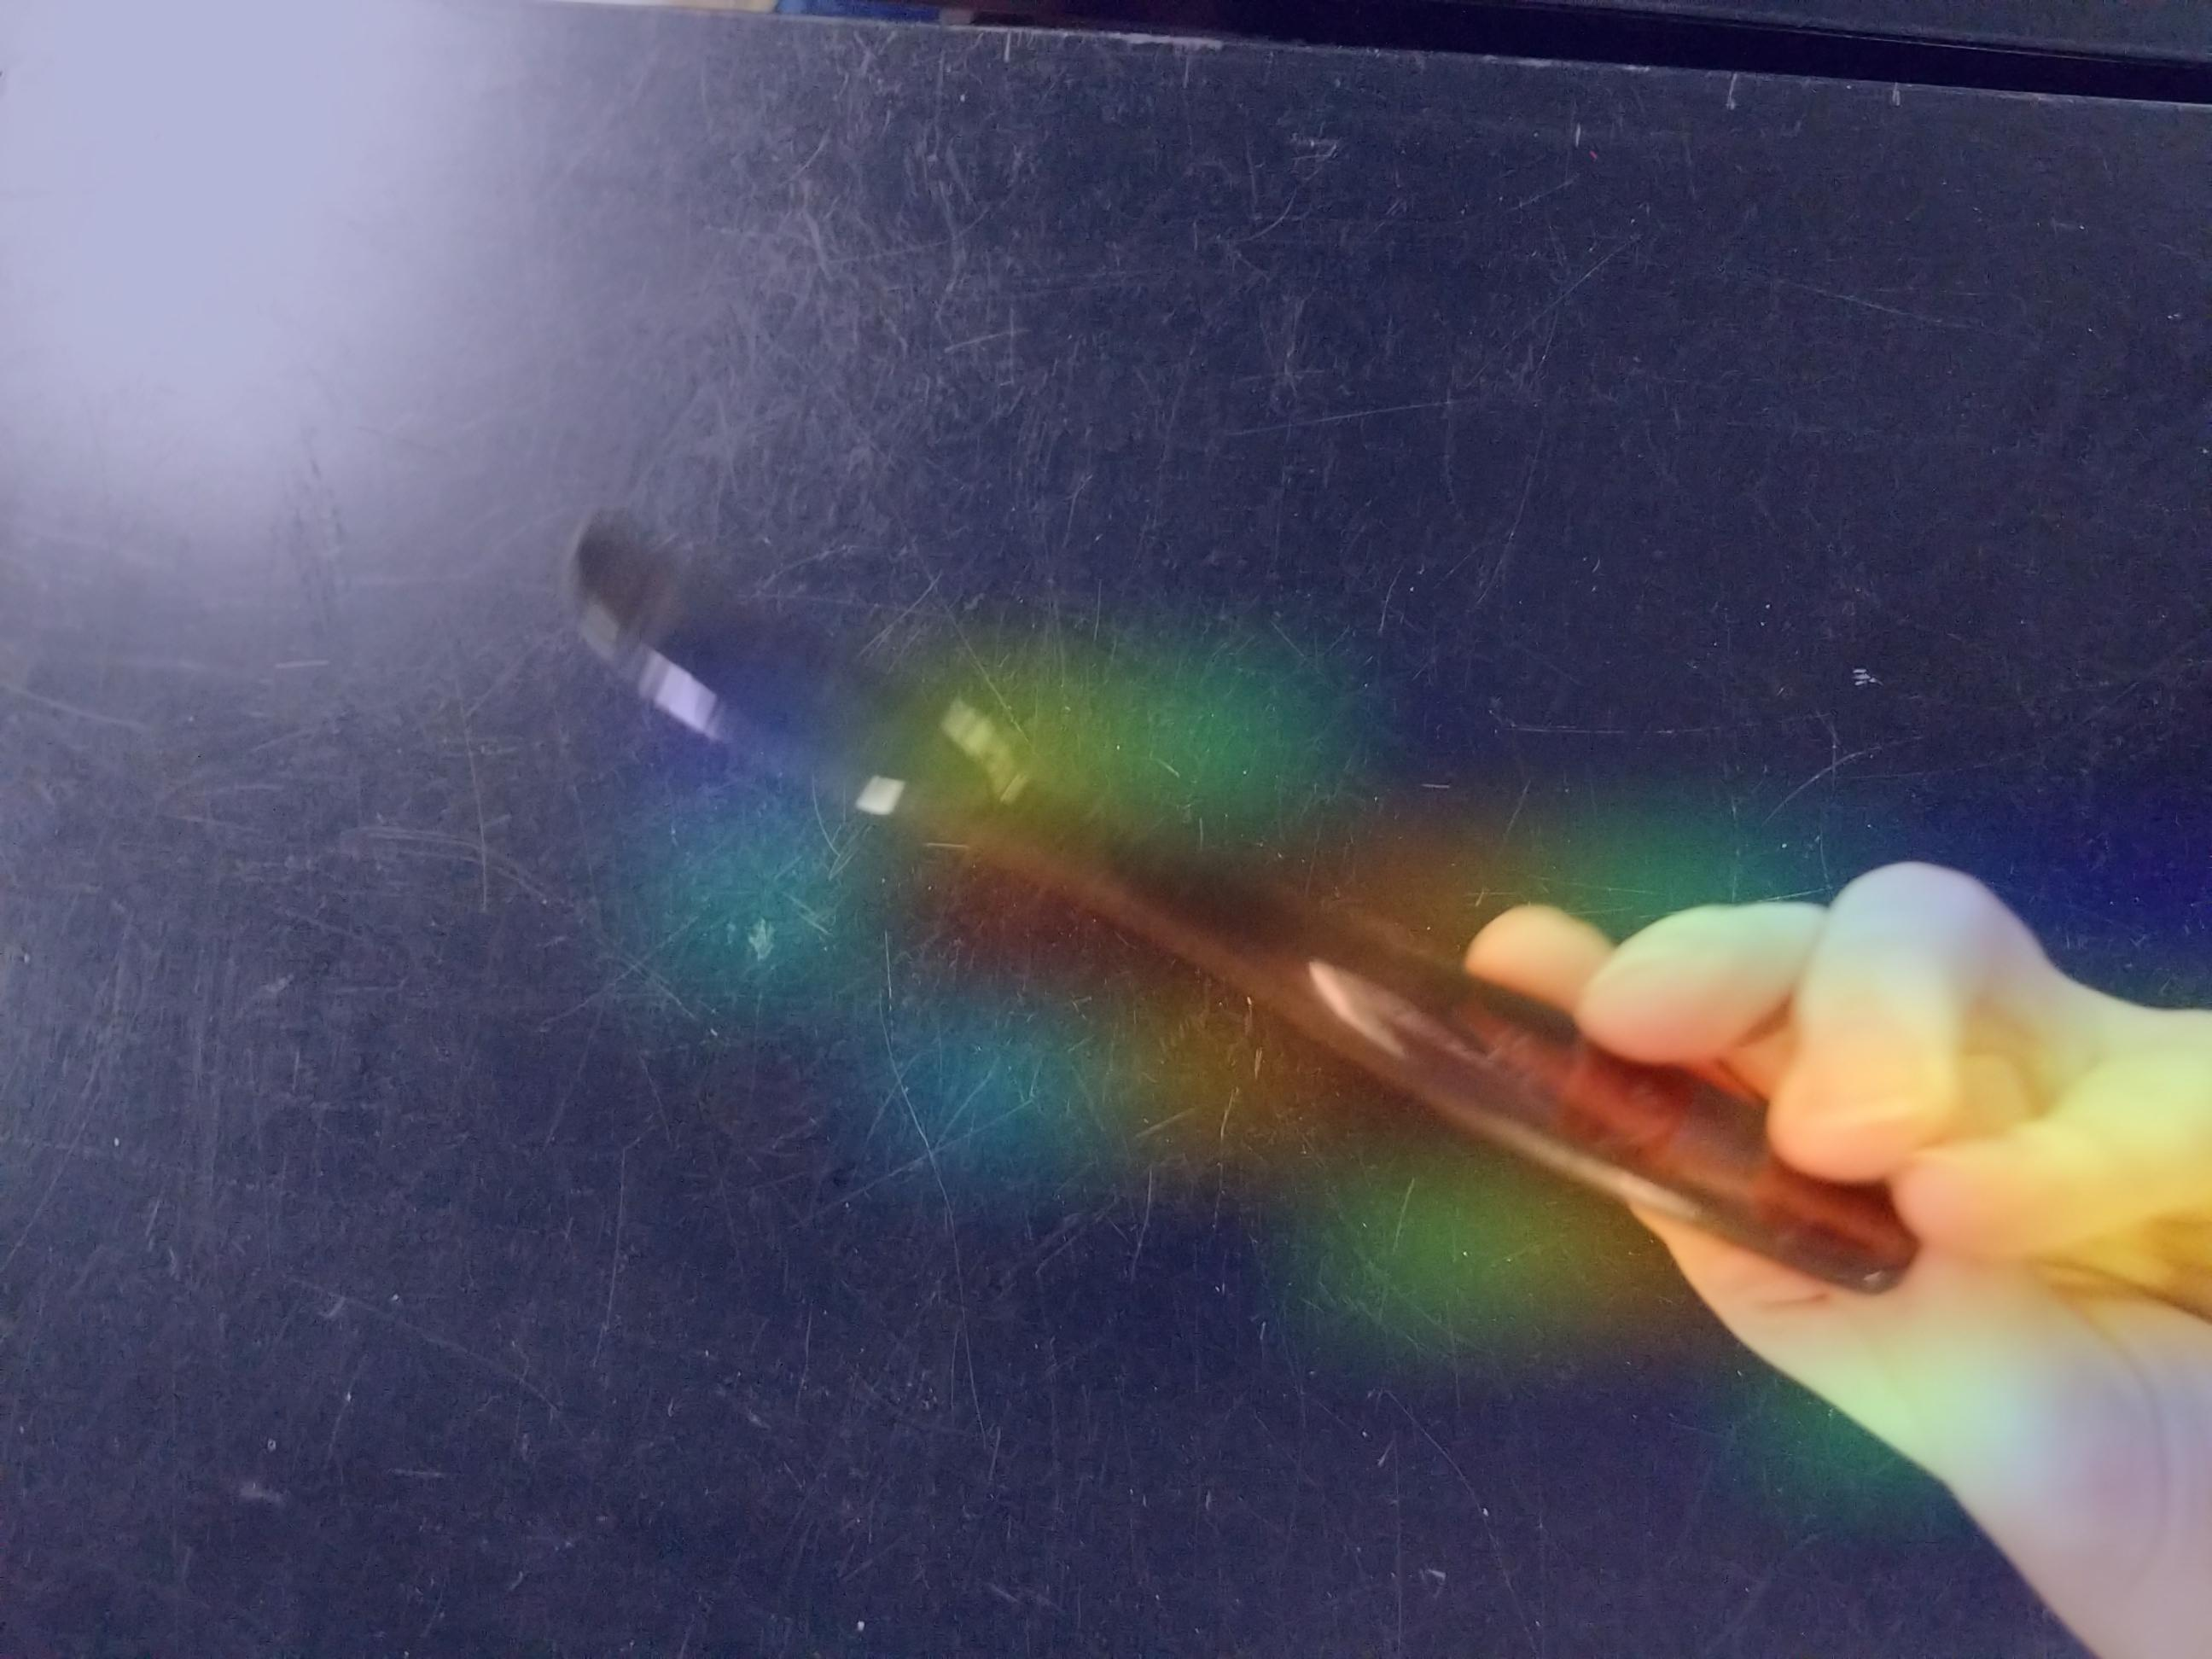

In [25]:
img_path = '/home/deeplearning/AI/datasets/OpenWaste/Experimental-big-9/val/Plastic TYPE 6 straws and cutlery/PXL_20231205_194126597.jpg'
display(Image(img_path, width=300, height=300))
img_size = (300, 300)
img_array = get_img_array(img_path, size=img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(img_path, heatmap, img_size=img_size)